In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
PATH_TO_PROJECT = '/content/drive/My Drive/Serious/'
# path to conll class as well as to conll data
PATH_TO_CONLL = PATH_TO_PROJECT + 'coNLL/'
PATH_TO_TAG2IDX = PATH_TO_CONLL + 'tag2idx.json'
PATH_TO_ONE_TAG2IDX = PATH_TO_CONLL + 'one_tag2idx.json'
PATH_TO_CHECKPOINT = '/content/drive/My Drive/models/'
PATH_TO_NEW_CHECKPOINT = PATH_TO_CHECKPOINT+'New_results/'

### Intall requirements

In [3]:
!pip install -r '/content/drive/My Drive/Serious/requirements.txt'

     |████████████████████████████████| 1.9MB 18.4MB/s 
     |████████████████████████████████| 634kB 41.5MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
     |████████████████████████████████| 3.3MB 49.4MB/s 
     |████████████████████████████████| 901kB 40.6MB/s 
     |████████████████████████████████| 2.1MB 48.2MB/s 
     |████████████████████████████████| 266kB 61.5MB/s 
     |████████████████████████████████| 122kB 58.6MB/s 
     |████████████████████████████████| 133kB 60.3MB/s 
     |████████████████████████████████| 1.2MB 46.4MB/s 
     |████████████████████████████████| 133kB 59.1MB/s 
     |████████████████████████████████| 163kB 52.0MB/s 
     |████████████████████████████████| 102kB 15.0MB/s 
     |████████████████████████████████| 81kB 12.5MB/s 
     |████████████████████████████████| 7.4MB 41.2MB/s 
     |████████████████████████████████| 71kB 11.2MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-

### Loading coNLL and my modules

In [4]:
import sys
sys.path.append(PATH_TO_PROJECT)
sys.path.append(PATH_TO_CONLL)

from importlib import reload
import conll as co

import data_loaders as dalo
import model_utils as mu

from bert_config import *
from elmo_config import *

In [5]:
conll = co.CoNLL(PATH_TO_CONLL)

In [6]:
# splitting raw data to sentences and labels
for typ in conll.types:
    conll.split_text_label(typ)

# define set of all labels
conll.create_set_of_labels()

for typ in conll.types:
    # for multiple heads of CRF layer
    conll.create_one_labeled_data(typ)

    # creating one_tag2idx dictionary
    conll.create_one_tag2idx(PATH_TO_ONE_TAG2IDX)
    conll.create_idx2one_tag()

In [7]:
# dict of tag2idx mapping for each CRF-head (one head responsible for 'LOC' etc.)
conll.one_tag2idx

{'LOC': {'B-LOC': 0, 'I-LOC': 3, 'O': 2, 'PAD': 1},
 'MISC': {'B-MISC': 0, 'I-MISC': 3, 'O': 2, 'PAD': 1},
 'ORG': {'B-ORG': 2, 'I-ORG': 3, 'O': 1, 'PAD': 0},
 'PER': {'B-PER': 2, 'I-PER': 0, 'O': 3, 'PAD': 1}}

In [ ]:
print(f"sen example: {conll.sentences['train'][0]}")
print(f"tags example: {conll.labels['train'][0]}")
print(f"tags example with only 'ORG' tag: {conll.one_tag_dict['train']['ORG'][0]}")
print(f"tags for CRF tags has labels: {conll.one_tag_dict['train'].keys()}")

sen example: ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
tags example: ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']
tags example with only 'ORG' tag: ['B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
tags for CRF tags has labels: dict_keys(['MISC', 'LOC', 'PER', 'ORG'])


### Importing external packages

In [8]:
import numpy as np
import torch
from torch import nn
from torch.optim import AdamW
from transformers import BertTokenizer, BertModel
from transformers import BertForTokenClassification
from allennlp.modules.elmo import Elmo, batch_to_ids

from torchcrf import CRF

from sklearn.model_selection import KFold, ParameterGrid

from transformers import get_linear_schedule_with_warmup

import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline

import json
import gc

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print(torch.cuda.get_device_name())

#model.to(device)

Tesla T4


### Creating dataloaders

In [10]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [ ]:
TAG_NAMES = ['ORG', 'LOC', 'PER']
NUM_OF_HEADS = len(TAG_NAMES)

In [ ]:
# in the second argument we pass list of tag names for every head of the model
train_dataset, train_sampler, train_dataloader = dalo.create_dataloader(conll, bert_tokenizer, TAG_NAMES)

# sanity check for output sizes
assert train_dataset[0][0].shape[0] == train_dataset[0][1].shape[0]
if NUM_OF_HEADS > 1:
  assert train_dataset[0][2].shape[0] == NUM_OF_HEADS
  assert train_dataset[0][2].shape[1] == train_dataset[0][0].shape[0]
else:
  assert len(train_dataset[0][2].shape) == NUM_OF_HEADS # == 1
  assert train_dataset[0][2].shape[0] == train_dataset[0][0].shape[0]
assert train_dataset[0][3].shape[0] == train_dataset[0][0].shape[0]

print(f"bert sentence shape: {train_dataset[0][0].shape}")
print(f"elmo sentence shape: {train_dataset[0][1].shape}")
print(f"number of heads: {train_dataset[0][2].shape[0] if NUM_OF_HEADS > 1 else 1}")
print(f"tokens len: {train_dataset[0][2].shape[1] if NUM_OF_HEADS > 1 else train_dataset[0][2].shape[0]}")
print(f"mask shape: {train_dataset[0][3].shape}")

bert sentence shape: torch.Size([173])
elmo sentence shape: torch.Size([173, 50])
number of heads: 3
tokens len: 173
mask shape: torch.Size([173])


In [ ]:
valid_dataset, valid_sampler, valid_dataloader = dalo.create_dataloader(conll, bert_tokenizer, TAG_NAMES,
                                                                        'valid', desired_pad=train_dataset[0][0].shape[0])

# sanity check for output sizes
assert valid_dataset[0][0].shape[0] == train_dataset[0][1].shape[0]
if NUM_OF_HEADS > 1:
  assert valid_dataset[0][2].shape[0] == NUM_OF_HEADS
  assert valid_dataset[0][2].shape[1] == train_dataset[0][0].shape[0]
else:
  assert len(valid_dataset[0][2].shape) == NUM_OF_HEADS # == 1
  assert valid_dataset[0][2].shape[0] == train_dataset[0][0].shape[0]
assert valid_dataset[0][3].shape[0] == train_dataset[0][0].shape[0]

print(f"bert sentence shape: {valid_dataset[0][0].shape}")
print(f"elmo sentence shape: {valid_dataset[0][1].shape}")

bert sentence shape: torch.Size([173])
elmo sentence shape: torch.Size([173, 50])


### Creating model

In [11]:
def freeze_bert_layers(bert, num_of_trainable=1):
    for name, par in bert.named_parameters():
        if sum([str(i) in name for i in range(12-num_of_trainable, 12)]) == 0:
            par.requires_grad = False

def unfreeze_bert_layers(bert, num_of_trainable=1):
    for name, par in bert.named_parameters():
        if sum([str(i) in name for i in range(12-num_of_trainable, 12)]) != 0:
            par.requires_grad = True

In [12]:
class BEbiC(nn.Module):
    """
    BERT+Elmo+biLSTM+CRFs
    """
    def __init__(self, tag_names, hidden_size=128, num_labels=4, elmo_layers=2, 
                 bert_layers=1, concat_bert=True, num_of_trainable_bert_layers=0, 
                 bilstm_layers=1, dropout=0):
        """
        Creates model
        
        Parameters
        ----------
        hidden_size: int, default=128
          LSTM parameter
        num_labels: int, defualt=4
          The number of each CRF labels (ex: B-LABEL, I-LABEL, O, PAD for multiple heads case)
        tag_names: list of str
          List of tag names for models heads
        elmo_layers: int, default=2
          Num of ELMo layers to be considered
        bert_layers: int, default=1
          Num of final BERT hidden layers to be used as embedding vector.
        concat_bert: bool, default=True
          Whether to concat (True) or sum (False) last BERT hidden layers.
        num_of_trainable_bert_layers: int, default=0
          Num of trainable bert layers.
        bilstm_layers: int, default=1
          Number of layers in biLSTM
        dropout: float, default=0
          Dropout value

        """

        super(BEbiC, self).__init__()

        self.hidden_size = hidden_size
        self.num_labels = num_labels
        self.tag_names = tag_names
        self.num_heads = len(self.tag_names)
        self.elmo_layers = elmo_layers
        self.bert_layers = bert_layers
        self.concat_bert = concat_bert
        self.num_of_trainable_bert_layers = num_of_trainable_bert_layers
        self.bilstm_layers = bilstm_layers
        self.dropout = dropout
        
        self.bert = BertForTokenClassification.from_pretrained(
                        BERT_MODEL,
                        output_hidden_states=True)
        
        #for pars in self.bert.parameters():
        #    pars.requires_grad = False
        freeze_bert_layers(self.bert, num_of_trainable=self.num_of_trainable_bert_layers)
        
        bert_embedding_dim = self.bert.config.to_dict()['hidden_size']

        self.elmo = Elmo(options_file, weight_file, self.elmo_layers, dropout=0, requires_grad=False)
        
        elmo_embedding_dim = 512 # it's always fixed

        
        if self.concat_bert:
          self.linear1 = nn.Linear(bert_embedding_dim*self.bert_layers+elmo_embedding_dim*self.elmo_layers, 1024)
        else:
          self.linear1 = nn.Linear(bert_embedding_dim+elmo_embedding_dim*self.elmo_layers, 1024)

        self.dp1 = nn.Dropout(self.dropout)
        
        self.bilstm = nn.LSTM(1024, self.hidden_size, self.bilstm_layers, 
                              bidirectional=True, dropout=self.dropout)
        self.active_body = True

        self.dp2 = nn.Dropout(self.dropout)

        self.heads = {}
        for i, tag in enumerate(self.tag_names):
            lin_crf = nn.ModuleDict({'linear': nn.Linear(self.hidden_size*2, self.num_labels),
                                     'crf': CRF(num_tags=self.num_labels, batch_first=True)})
            self.heads[tag] = lin_crf

        self.heads = nn.ModuleDict(self.heads)
        self.active_heads = {head: True for head in self.heads.keys()}

    def get_model_pars_dict(self):
        """
        Returns dict with described model's parameters.
        
        """
        pars = {}
        pars['hidden_size'] = self.hidden_size
        pars['num_labels'] = self.num_labels
        pars['tag_names'] = self.tag_names
        pars['elmo_layers'] = self.elmo_layers
        pars['bert_layers'] = self.bert_layers
        pars['concat_bert'] = int(self.concat_bert)
        pars['bilstm_layers'] = self.bilstm_layers
        pars['dropout'] = self.dropout

        return pars

    def add_head(self, tag_name):
        """
        Adds new head to the model

        """
        self.tag_names.append(tag_name)
        self.num_heads += 1
        lin_crf = nn.ModuleDict({'linear': nn.Linear(self.hidden_size*2, self.num_labels),
                                     'crf': CRF(num_tags=self.num_labels, batch_first=True)})
        self.heads.update({tag_name: lin_crf})
        self.active_heads[tag_name] = True


    def shared_forward(self, bert_ids, elmo_ids, attention_mask):
        """
        Forward propogate of model shared layers.
        
        Parameters
        ----------
        bert_ids:
        elmo_ids:
        attention_mask:
        
        Returns
        -------
        Bilstm logits with shape (seq_len, batch, 2*self.hidden_size)
        
        """

        mask = attention_mask.byte()
        bert_hiddens = self.bert(bert_ids, attention_mask=mask)[1]
        elmo_hiddens = self.elmo(elmo_ids)

        if self.concat_bert:
            bert_embedding = torch.cat(bert_hiddens[-self.bert_layers:], dim=2)
        else:
            emb_sum = 0
            for h in bert_hiddens[-self.bert_layers:]:
                emb_sum += h
            bert_embedding = emb_sum

        elmo_bert_embeddings = torch.clone(bert_embedding)
        for el_hi in elmo_hiddens['elmo_representations']:
            elmo_bert_embeddings = torch.cat((elmo_bert_embeddings, el_hi), dim=-1)

        linear1_output = nn.functional.relu(self.linear1(elmo_bert_embeddings))
        linear1_output = self.dp1(linear1_output)

        bilstm_output, (h_n, c_n) = self.bilstm(linear1_output)
        bilstm_output = self.dp2(bilstm_output)

        return bilstm_output
    
    def get_one_head_loss(self, bilstm_logits, head_labels, attention_mask, head_tag):
        """
        Returns negative log-likelihood for one head.
        You should run it after shared forward.

        Parameters
        ----------
        bilstm_logits:
        head_labels:
        attention_mask:
        head_tag: str
          Key of self.heads dictionary.
        
        Returns
        -------
        Loss

        """
        lin_out = nn.functional.relu(self.heads[head_tag]['linear'](bilstm_logits))
        loss = -1*self.heads[head_tag]['crf'].forward(lin_out, head_labels, mask=attention_mask.byte())
        return loss
    
    def get_one_head_seq(self, bilstm_logits, attention_mask, head_tag):
        """
        Returns the most likely sequence of labels for the given head.
        You should run it after shared forward.

        Parameters
        ----------
        bilstm_logits:
        attention_mask:
        head_tag: str
          Key of self.heads dictionary.
        
        Returns
        -------
        List
        """
      
        lin_out = nn.functional.relu(self.heads[head_tag]['linear'](bilstm_logits))
        seq = self.heads[head_tag]['crf'].decode(lin_out, mask=attention_mask.byte())
        return seq
    
    def forward(self, bert_ids, elmo_ids, head_labels, attention_mask):
        """
        Forward model pass.
        
        Parameters
        ----------
        bert_ids:
        elmo_ids:
        head_labels:
        attention_mask:
        
        Returns
        -------
        Total loss for all heads.

        """

        mask = attention_mask.byte()
        bilstm_logits = self.shared_forward(bert_ids, elmo_ids, mask)
        head_loss = 0

        for i, tag in enumerate(self.heads.keys()):
          # if head is not active - we don't calculate loss from it
          #if not self.active_heads[tag]:
          #    continue
          _one_head_labels = head_labels[:,i,:] if len(self.heads.keys()) > 1 else head_labels
          head_loss += self.get_one_head_loss(bilstm_logits, _one_head_labels, mask, tag)
        return head_loss
    
    def freeze_head(self, head_tag):
        """
        Freezes model's head parameters.

        """
        if head_tag not in self.heads.keys():
            raise ValueError(f"Unknown head tag. Please, give one of {self.heads.keys()}")
        
        for parameter in self.heads[head_tag].parameters():
            parameter.requires_grad = False
        
        self.active_heads[head_tag] = False
    
    def unfreeze_head(self, head_tag):
        """
        Unfreezes model's head parameters.

        """
        if head_tag not in self.heads.keys():
            raise ValueError(f"Unknown head tag. Please, give one of {self.heads.keys()}")
        
        for parameter in self.heads[head_tag].parameters():
            parameter.requires_grad = True
        
        self.active_heads[head_tag] = True
      
    def freeze_body(self):
        """
        Freezes model's body parameters.

        """
        freeze_bert_layers(self.bert, num_of_trainable=0)

        for parameter in self.linear1.parameters():
            parameter.requires_grad = False
        for parameter in self.bilstm.parameters():
            parameter.requires_grad = False
        
        self.active_body = False
    
    def unfreeze_body(self):
        """
        Freezes model's body parameters.

        """
        unfreeze_bert_layers(self.bert, num_of_trainable=self.num_of_trainable_bert_layers)

        for parameter in self.linear1.parameters():
            parameter.requires_grad = True
        for parameter in self.bilstm.parameters():
            parameter.requires_grad = True
        
        self.active_body = True
    
    def init_weights(self):
        """
        Initializes models trainable weights (in bilstm and linear layers) 
        according to Xavier uniform distribution.

        """

        for name, param in model.named_parameters():
            if ('linear' in name or 'bilstm' in name) and \
            ('weight' in name) and \
            ('bert' not in name and 'elmo' not in name) and \
            param.requires_grad:
                torch.nn.init.xavier_uniform_(param)
    

In [ ]:
model = BEbiC(tag_names=TAG_NAMES, hidden_size=512, bert_layers=2)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [ ]:
N_EPOCHS = 10
total_steps = len(train_dataloader) *  N_EPOCHS

In [ ]:
model.tag_names

['ORG', 'LOC', 'PER', 'MISC']

In [ ]:
optimizer = AdamW(params=model.parameters(),lr=5e-4)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

if device.type != 'cpu':
    model.to(device)

loss_value, head_results = mu.train(model, train_dataloader, optimizer, device, conll, scheduler, n_epoch=N_EPOCHS,
                                valid_dataloader=valid_dataloader, path_to_save=PATH_TO_CHECKPOINT+'bebic_with_dp_4_tags.pth')

In [ ]:
mu.eval_model(model, valid_dataloader, device, conll)

### Loading pretrained model

In [ ]:
from models import *

In [ ]:
bert_tokenizer, model, opt_state, model_pars = mu.load_checkpoint(PATH_TO_CHECKPOINT+'BEbic_9_state_dict.pth',
                                                                  PATH_TO_CHECKPOINT+'BEbic_9_tokenizer.pth')

In [ ]:
model.heads

ModuleDict(
  (ORG): ModuleDict(
    (linear): Linear(in_features=1024, out_features=4, bias=True)
    (crf): CRF(num_tags=4)
  )
  (LOC): ModuleDict(
    (linear): Linear(in_features=1024, out_features=4, bias=True)
    (crf): CRF(num_tags=4)
  )
  (PER): ModuleDict(
    (linear): Linear(in_features=1024, out_features=4, bias=True)
    (crf): CRF(num_tags=4)
  )
)

In [ ]:
model_pars

{'bert_layers': 2,
 'bilstm_layers': 1,
 'concat_bert': 1,
 'elmo_layers': 2,
 'hidden_size': 512,
 'num_labels': 4,
 'tag_names': ['ORG', 'LOC', 'PER']}

In [ ]:
optimizer = AdamW(params=model.parameters(),lr=3e-4)
optimizer.load_state_dict(opt_state)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

model.to(device)

In [ ]:
valid_dataset, valid_sampler, valid_dataloader = dalo.create_dataloader(conll, bert_tokenizer, 
                                                                        model_pars['tag_names'], 
                                                                        'valid', desired_pad=173)

In [ ]:
head_result, mean_loss, mean_acc, mean_f1 = mu.eval_model(model, valid_dataloader, device, conll)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


In [ ]:
head_result

{'LOC': {'acc': 0.9913228024930153, 'f1': 0.9035911602209944},
 'ORG': {'acc': 0.9772458628841607, 'f1': 0.634631886047709},
 'PER': {'acc': 0.9769100580270793, 'f1': 0.3787528868360277}}

#### Continue to train pretrained model

In [ ]:
TAG_NAMES = ['ORG', 'LOC', 'PER']
NUM_OF_HEADS = len(TAG_NAMES)

# in the second argument we pass list of tag names for every head of the model
train_dataset, train_sampler, train_dataloader = dalo.create_dataloader(conll, bert_tokenizer, TAG_NAMES)

In [ ]:
N_EPOCHS = 5
total_steps = len(train_dataloader) *  N_EPOCHS

In [ ]:
optimizer = AdamW(params=model.parameters(),lr=1e-4)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

if device.type != 'cpu':
    model.to(device)

loss_value, head_results = mu.train(model, train_dataloader, optimizer, device, conll, scheduler, n_epoch=N_EPOCHS,
                                valid_dataloader=valid_dataloader, path_to_save=PATH_TO_CHECKPOINT)

### Select params with grid search

Let's try to select the best params for our model 'at the start' (when we have not all tags).

In [ ]:
TAG_NAMES = ['ORG', 'LOC', 'PER']
NUM_OF_HEADS = len(TAG_NAMES)

# in the second argument we pass list of tag names for every head of the model
train_dataset, train_sampler, train_dataloader = dalo.create_dataloader(conll, bert_tokenizer, TAG_NAMES, indexes=np.arange(1000))


valid_dataset, valid_sampler, valid_dataloader = dalo.create_dataloader(conll, bert_tokenizer, TAG_NAMES,
                                                                        'valid', desired_pad=train_dataset[0][0].shape[0],
                                                                        indexes=np.arange(250))


In [ ]:
N_EPOCHS = 15
total_steps = len(train_dataloader) *  N_EPOCHS

In [ ]:
param_grid = {
    'hidden_size': [512],
    'lr': [3e-4, 5e-4, 1e-3],
    'bert_layers': [2],
    'bilstm_layers': [1, 2],
    'dropout': [0, 0.25, 0.5],
    'max_grad_norm': [None, 228]
}


grid = ParameterGrid(param_grid)

results_dict = {}

for m, ps in enumerate(grid):
    print(f"Model #{m} of {len(grid)}")
    results_dict[m] = {}
    results_dict[m]['params'] = ps

    model = BEbiC(tag_names=TAG_NAMES,
                  hidden_size=ps['hidden_size'], bert_layers=ps['bert_layers'],
                  dropout=ps['dropout'])

    optimizer = AdamW(params=model.parameters(),lr=ps['lr'])

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    if device.type != 'cpu':
        model.to(device)

    torch.cuda.empty_cache()
    
    loss_value, head_results = mu.train(model, train_dataloader, optimizer, device, conll, scheduler, n_epoch=N_EPOCHS,
                                max_grad_norm=ps['max_grad_norm'],
                                valid_dataloader=valid_dataloader, save_model=False)
    

    results_dict[m]['head_results'] = head_results
    

with open(PATH_TO_CHECKPOINT+'bebic_gridsearch_results.json', "w") as w:
    json.dump(results_dict, w)

In [ ]:
mean_f1s = {k: np.mean([v['head_results'][tag]['f1'][-1] for tag in v['head_results'].keys()]) for k, v in results_dict.items()}
print(mean_f1s)

{0: 0.2679059168734685, 1: 0.39203286847293395, 2: 0.09669211195928752, 3: 0.7876130135949433, 4: 0.2900665330819922, 5: 0.3667632850241546, 6: 0.6000593071898404, 7: 0.6425540825402759, 8: 0.583669454008854, 9: 0.5754897484011977, 10: 0.3450359839307026, 11: 0.1635864564325707, 12: 0.7935277492329728, 13: 0.5383463409116617, 14: 0.6157668582823776, 15: 0.8107453740345906, 16: 0.3359081779329673, 17: 0.828276269248082, 18: 0.3207379775496432, 19: 0.279613254899059, 20: 0.0, 21: 0.4092689278410004, 22: 0.1368759374330405, 23: 0.21609195402298853, 24: 0.2979867202967546, 25: 0.6543898994403518, 26: 0.8237526576548474, 27: 0.3745669656698656, 28: 0.3605909827210749, 29: 0.6484876889086819, 30: 0.7749038774845225, 31: 0.8242677147839608, 32: 0.77657496109267, 33: 0.5574397985857636, 34: 0.3175805675805676, 35: 0.3956337496949393}


In [ ]:
print(f"best results: {results_dict[np.argmax(list(mean_f1s.values()))]['params']}")

best results: {'bert_layers': 2, 'bilstm_layers': 1, 'dropout': 0.5, 'hidden_size': 512, 'lr': 0.001, 'max_grad_norm': 228}


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

#print(f'The model has {count_parameters(model)} trainable parameters')

The model has 23110236 trainable parameters


So, we have the same almost results as we had in multilabel model case.

### Model gradients analysis

Let's take trained model to inspect its gradients norms. We need trained model because gradients of raw parameters are too huge.

In [ ]:
checkpoint = torch.load(PATH_TO_CHECKPOINT+'bebic_with_dp_4_tags.pth')
model = checkpoint['model']
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [ ]:
def get_grad_norm(model, many_heads=False):
    total_norm = 0
    if many_heads:
        body_norm = 0
        heads_norms = {head: 0 for head in model.heads.keys()}
    
    for name, p in model.named_parameters():
        if p.requires_grad:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
            if many_heads:
                if 'heads' not in name:
                    body_norm += param_norm
                else:
                    for k in heads_norms.keys():
                        if k in name:
                            heads_norms[k] += param_norm
    total_norm = total_norm ** (1. / 2)
    if many_heads:
        return total_norm, body_norm, heads_norms
    return total_norm

In [ ]:
model.to(device)

In [ ]:
model.train()
total_grad_norms = []
body_grad_norms = []
heads_grad_norms = {head: [] for head in model.heads.keys()}

for batch in train_dataloader:
    if device.type != 'cpu':
          batch = tuple(t.to(device) for t in batch)
    b_bert_ids, b_elmo_ids, b_labels, b_input_mask = batch
    model.zero_grad()

    loss = model(b_bert_ids, b_elmo_ids, b_labels, b_input_mask.byte())
    loss.backward()

    total_norm, body_norm, heads_norms = get_grad_norm(model, many_heads=True)
    total_grad_norms.append(total_norm)
    body_grad_norms.append(body_norm.item())
    for head in heads_grad_norms.keys():
        heads_grad_norms[head].append(heads_norms[head].item())
    
    del batch, loss, b_bert_ids, b_elmo_ids, b_labels, b_input_mask
    gc.collect()
    torch.cuda.empty_cache()


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


In [ ]:
body_grad_norms = [x.item() for x in body_grad_norms]
for head in heads_grad_norms.keys():
    heads_grad_norms[head] = [x.item() for x in heads_grad_norms[head]]

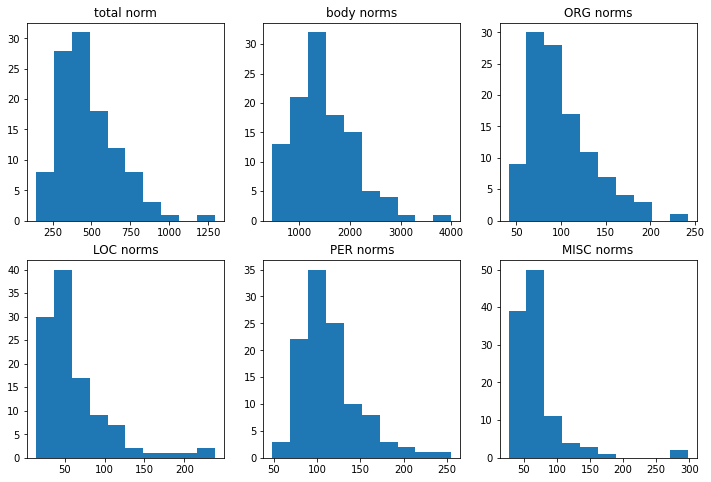

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
_ = axes[0][0].hist(total_grad_norms)
axes[0][0].set_title('total norm')
_ = axes[0][1].hist(body_grad_norms)
axes[0][1].set_title('body norms')
for i, head in enumerate(heads_grad_norms.keys()):
    j = i+2
    _ = axes[j//3][j%3].hist(heads_grad_norms[head])
    axes[j//3][j%3].set_title(f'{head} norms')

plt.show()

Body's norms are mainly greater than total ones and it's ok because gradients may take negative values.

In [ ]:
print(f'Mean total gradient norm: {np.mean(total_grad_norms)}')
print(f'Mean body gradient norm: {np.mean(body_grad_norms)}')
for head in heads_grad_norms.keys():
    print(f'Mean {head} gradient norm: {np.mean(heads_grad_norms[head])}')

Mean total gradient norm: 479.1625377599561
Mean body gradient norm: 1493.7607202703302
Mean ORG gradient norm: 100.52260801141912
Mean LOC gradient norm: 61.176813992587
Mean PER gradient norm: 113.64938697814941
Mean MISC gradient norm: 69.2078110261397


So, let's restrict the overall model grandients size to the norm of 500.

### K-fold for multihead model

In [ ]:
N_FOLDS = 5
RANDOM_SEED = 42
N_EPOCHS = 10
BATCH_SIZE = 128

TAG_NAMES = ['ORG', 'LOC', 'PER']
NUM_OF_HEADS = len(TAG_NAMES)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [ ]:
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
all_loss_values = []
all_head_results = []

for i, (train_index, valid_index) in enumerate(kf.split(train_dataset)):
    print(f"FOLD #{i}\n")
    # train_dataset based on conll and defined above specially for multiple-head model input
    train_fold = torch.utils.data.Subset(train_dataset, train_index)
    valid_fold = torch.utils.data.Subset(train_dataset, valid_index)
    
    _train_dataloader = torch.utils.data.DataLoader(train_fold, batch_size=BATCH_SIZE)
    _valid_dataloader = torch.utils.data.DataLoader(valid_fold, batch_size=BATCH_SIZE)

    total_steps = len(train_fold) *  N_EPOCHS

    model = BEbiC(tag_names=TAG_NAMES, hidden_size=512, bert_layers=2, dropout=0.5)
    model.to(device)

    optimizer = AdamW(params=model.parameters(),lr=1e-3)

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    loss_value, head_results = mu.train(model, _train_dataloader, optimizer, device, conll, scheduler, n_epoch=N_EPOCHS,
                                max_grad_norm=500, valid_dataloader=_valid_dataloader, save_model=False)
    
    print(f"Head_results:\n{head_results}")
    all_loss_values.append(loss_value)
    all_head_results.append(head_results)

    # cleaning
    del model
    gc.collect()
    torch.cuda.empty_cache()

    with open(PATH_TO_CHECKPOINT+f"New_results/bebic_5folds/Bebic-5fold_head_results_fold{i}.json", "w") as f:
        json.dump(head_results, f)

    with open(PATH_TO_CHECKPOINT+f"New_results/bebic_5folds/Bebic-5fold_loss_values_fold{i}.json", "w") as f:
        json.dump(loss_value, f)


#with open(PATH_TO_CHECKPOINT+"BEbic-5fold_head_results.json", "w") as f:
#    json.dump(all_head_results, f)

#with open(PATH_TO_CHECKPOINT+"BEbic-5fold_loss_values.json", "w") as f:
#    json.dump(all_loss_values, f)

## Train model with 3 heads and best params

In [ ]:
TAG_NAMES = ['ORG', 'LOC', 'PER']
NUM_OF_HEADS = len(TAG_NAMES)

In [ ]:
train_dataset, train_sampler, train_dataloader = dalo.create_dataloader(conll, bert_tokenizer, TAG_NAMES, batch_size=64)

In [ ]:
valid_dataset, valid_sampler, valid_dataloader = dalo.create_dataloader(conll, bert_tokenizer, TAG_NAMES,
                                                                        'valid', desired_pad=train_dataset[0][0].shape[0])

In [ ]:
model = BEbiC(tag_names=TAG_NAMES, hidden_size=512, bert_layers=2, dropout=0.5)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [ ]:
N_EPOCHS = 12
total_steps = len(train_dataloader) *  N_EPOCHS

In [ ]:
optimizer = AdamW(params=model.parameters(),lr=1e-3)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

if device.type != 'cpu':
    model.to(device)

loss_value, head_results = mu.train(model, train_dataloader, optimizer, device, conll, scheduler, n_epoch=N_EPOCHS, max_grad_norm=500,
                                valid_dataloader=valid_dataloader, path_to_save=PATH_TO_NEW_CHECKPOINT+'best_bebic_3_tags.pth')

In [ ]:
mu.eval_model(model, valid_dataloader, device, conll)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


({'LOC': {'acc': 0.9939689447668171, 'f1': 0.9363243695137244},
  'ORG': {'acc': 0.9802681065978939, 'f1': 0.6515723270440251},
  'PER': {'acc': 0.9961718246292715, 'f1': 0.9532004830917874}},
 219.55645321798156,
 0.9901362919979941,
 0.8470323932165122)

We have very good quality on all labels.

## The fourth head trained on old data with new tag

In [ ]:
checkpoint = torch.load(PATH_TO_NEW_CHECKPOINT+'best_bebic_3_tags.pth')
model = checkpoint['model']
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [ ]:
model.heads

ModuleDict(
  (ORG): ModuleDict(
    (linear): Linear(in_features=1024, out_features=4, bias=True)
    (crf): CRF(num_tags=4)
  )
  (LOC): ModuleDict(
    (linear): Linear(in_features=1024, out_features=4, bias=True)
    (crf): CRF(num_tags=4)
  )
  (PER): ModuleDict(
    (linear): Linear(in_features=1024, out_features=4, bias=True)
    (crf): CRF(num_tags=4)
  )
)

In [ ]:
model.train()

In [ ]:
model.add_head('MISC')

In [ ]:
for head in ['LOC', 'ORG', 'PER']:
    model.freeze_head(head)

In [ ]:
model.active_heads

{'LOC': False, 'MISC': True, 'ORG': False, 'PER': False}

Now let's try to keep 85% of examples with one or more tags MISC and 15% without it. So, we would simulate the real case of receiving new data with new tag.

In [ ]:
TAG_NAMES = ['ORG', 'LOC', 'PER', 'MISC']#list(model.heads.keys())
NUM_OF_HEADS = len(TAG_NAMES)
BATCH_SIZE=32
RANDOM_SEED=42
N_EPOCHS = 15

In [ ]:
TAG_NAMES

['ORG', 'LOC', 'PER', 'MISC']

In [ ]:
indexes_with_misc = [i for i, s in enumerate(conll.labels['train']) if 'B-MISC' in s]
indexes_without_misc = [i for i in range(len(conll.labels['train'])) if i not in indexes_with_misc]

In [ ]:
print(f"# sentences with MISC: {len(indexes_with_misc)}")
print(f"# sentences without MISC: {len(indexes_without_misc)}")

# sentences with MISC: 2698
# sentences without MISC: 11343


Also, let's consider multiple "random" cases.

In [ ]:
results_dict = {}
for freezed_epochs in range(3,4):
  print(f"FREEZED_EPOCHS:{freezed_epochs}")
  seed_results_dict = {}
  for seed in [1, 12, 123, 1234, 12345]:
    print(f"SEED:{seed}")
    np.random.seed(seed)
    seed_results_dict[seed] = {}

    for n_train_samples in range(100, 351, 50):
        print(f"NUMBER OF TRAIN SAMPLES: {n_train_samples}")
        
        torch.cuda.empty_cache()

        checkpoint = torch.load(PATH_TO_NEW_CHECKPOINT+'best_bebic_3_tags.pth')
        model = checkpoint['model']
        model.load_state_dict(checkpoint['state_dict'])
        model.train()
        model.add_head('MISC')

        for head in ['LOC', 'ORG', 'PER']:
            model.freeze_head(head)
        
        # I just remember that max sequence length in train is 173
        all_valid_dataset, all_valid_sampler, all_valid_dataloader = dalo.create_dataloader(conll, bert_tokenizer, TAG_NAMES,
                                                                            'valid', desired_pad=173,
                                                                            batch_size=128)

        # train indexes
        n_train_with_misc = int(n_train_samples*0.85)
        train_misk_indexes = np.random.choice(indexes_with_misc, n_train_with_misc)
        train_nmisk_indexes = np.random.choice(indexes_without_misc, n_train_samples-n_train_with_misc)
        train_indexes = np.append(train_misk_indexes, train_nmisk_indexes)

        # let's create small validation data with the same proportion of MISC samples from the train data
        n_valid_samples = int(n_train_samples/4)
        _idxes_with_misc = [i for i in indexes_with_misc if i not in train_misk_indexes]
        _idxes_without_misc = [i for i in indexes_without_misc if i not in train_nmisk_indexes]

        # validation indexes
        n_valid_with_misc = int(n_valid_samples*0.85)
        valid_misk_indexes = np.random.choice(_idxes_with_misc, n_valid_with_misc)
        valid_nmisk_indexes = np.random.choice(_idxes_without_misc, n_valid_samples-n_valid_with_misc)
        valid_indexes = np.append(valid_misk_indexes, valid_nmisk_indexes)

        train_dataset, train_sampler, train_dataloader = dalo.create_dataloader(conll, bert_tokenizer, TAG_NAMES, 
                                                                      desired_pad=173, batch_size=BATCH_SIZE,
                                                                      indexes=train_indexes)
        
        valid_dataset, valid_sampler, valid_dataloader = dalo.create_dataloader(conll, bert_tokenizer, TAG_NAMES,
                                                                            desired_pad=173, batch_size=BATCH_SIZE,
                                                                            indexes=valid_indexes)
        
        total_steps = len(train_dataloader) *  N_EPOCHS

        optimizer = AdamW(params=model.parameters(),lr=1e-3)

        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=total_steps
        )

        if device.type != 'cpu':
            model.to(device)

        model.freeze_body()

        loss_value, head_results = mu.train(model, train_dataloader, optimizer, 
                                            device, conll, scheduler, 
                                            n_epoch=freezed_epochs, 
                                            max_grad_norm=500,
                                            valid_dataloader=valid_dataloader,
                                            save_model=False)
        
        seed_results_dict[seed][n_train_samples] = {}
        seed_results_dict[seed][n_train_samples]['freezed_loss_values'] = loss_value
        seed_results_dict[seed][n_train_samples]['freezed_head_results'] = head_results
        
        model.unfreeze_body()

        loss_value, head_results = mu.train(model, train_dataloader, optimizer, 
                                            device, conll, scheduler, 
                                            n_epoch=N_EPOCHS-freezed_epochs,
                                            max_grad_norm=500,
                                            valid_dataloader=valid_dataloader,
                                            save_model=False)

        seed_results_dict[seed][n_train_samples]['loss_values'] = loss_value
        seed_results_dict[seed][n_train_samples]['head_results'] = head_results

        # eval model on the all validation data
        head_results_all, mean_loss, mean_acc, mean_f1 = mu.eval_model(model, all_valid_dataloader, device, conll)
        print(f"mean validation loss: {mean_loss}")
        print(f"mean validation accuracy: {mean_acc}")
        print(f"mean validation f1-score: {mean_f1}")

        seed_results_dict[seed][n_train_samples]["head_results_all"] = head_results_all
        seed_results_dict[seed][n_train_samples]["mean_loss"] = mean_loss
        seed_results_dict[seed][n_train_samples]["mean_acc"] = mean_acc
        seed_results_dict[seed][n_train_samples]["mean_f1"] = mean_f1
  
  results_dict[f"{freezed_epochs}_freezed_epochs"] = seed_results_dict

  with open(PATH_TO_NEW_CHECKPOINT+f"4th_head/results_dict_freezed{freezed_epochs}.json", "w") as f:
      json.dump(seed_results_dict, f)


## The 4th head trained on completely new data from the test set

In [ ]:
TAG_NAMES = ['ORG', 'LOC', 'PER', 'MISC']#list(model.heads.keys())
NUM_OF_HEADS = len(TAG_NAMES)
BATCH_SIZE=32
RANDOM_SEED=42
N_EPOCHS = 15

Let's try to keep 85% of examples with one or more tags MISC and 15% without it. But now, let's use data from test set.

In [ ]:
indexes_with_misc = [i for i, s in enumerate(conll.labels['test']) if 'B-MISC' in s]
indexes_without_misc = [i for i in range(len(conll.labels['test'])) if i not in indexes_with_misc]

In [ ]:
print(f"# sentences with MISC: {len(indexes_with_misc)}")
print(f"# sentences without MISC: {len(indexes_without_misc)}")

# sentences with MISC: 563
# sentences without MISC: 2890


Let's "cut" test set to divide it on 'new data for the 4th head' / 'small test set'.

In [ ]:
indexes_with_misc = indexes_with_misc[:300]
indexes_without_misc = indexes_without_misc[:200]

In [ ]:
results_dict = {}
for freezed_epochs in range(0,1):
  print(f"FREEZED_EPOCHS:{freezed_epochs}")
  seed_results_dict = {}
  for seed in [1, 12, 123, 1234, 12345]:
    print(f"SEED:{seed}")
    np.random.seed(seed)
    seed_results_dict[seed] = {}

    for n_train_samples in range(100, 351, 50):
        print(f"NUMBER OF TRAIN SAMPLES: {n_train_samples}")
        
        torch.cuda.empty_cache()

        checkpoint = torch.load(PATH_TO_NEW_CHECKPOINT+'best_bebic_3_tags.pth')
        model = checkpoint['model']
        model.load_state_dict(checkpoint['state_dict'])
        model.train()
        model.add_head('MISC')

        for head in ['LOC', 'ORG', 'PER']:
            model.freeze_head(head)
        
        # I just remember that max sequence length in train is 173
        all_valid_dataset, all_valid_sampler, all_valid_dataloader = dalo.create_dataloader(conll, bert_tokenizer, TAG_NAMES,
                                                                            'valid', desired_pad=173,
                                                                            batch_size=128)

        # train indexes
        n_train_with_misc = int(n_train_samples*0.85)
        train_misk_indexes = np.random.choice(indexes_with_misc, n_train_with_misc)
        train_nmisk_indexes = np.random.choice(indexes_without_misc, n_train_samples-n_train_with_misc)
        train_indexes = np.append(train_misk_indexes, train_nmisk_indexes)

        train_dataset, train_sampler, train_dataloader = dalo.create_dataloader(conll, bert_tokenizer, TAG_NAMES, 
                                                                      'test', desired_pad=173, batch_size=BATCH_SIZE,
                                                                      indexes=train_indexes)
        # now we don't create small validation dataset in order to have not too small residual test set
        # but we still would validate on all validation data
        
        total_steps = len(train_dataloader) *  N_EPOCHS

        optimizer = AdamW(params=model.parameters(),lr=1e-3)

        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=total_steps
        )

        if device.type != 'cpu':
            model.to(device)

        model.freeze_body()

        loss_value = mu.train(model, train_dataloader, optimizer, 
                                            device, conll, scheduler, 
                                            n_epoch=freezed_epochs, 
                                            max_grad_norm=500,
                                            save_model=False)
        
        seed_results_dict[seed][n_train_samples] = {}
        seed_results_dict[seed][n_train_samples]['freezed_loss_values'] = loss_value
        #seed_results_dict[seed][n_train_samples]['freezed_head_results'] = head_results
        
        model.unfreeze_body()

        loss_value = mu.train(model, train_dataloader, optimizer, 
                                            device, conll, scheduler, 
                                            n_epoch=N_EPOCHS-freezed_epochs,
                                            max_grad_norm=500,
                                            save_model=False)

        seed_results_dict[seed][n_train_samples]['loss_values'] = loss_value
        #seed_results_dict[seed][n_train_samples]['head_results'] = head_results

        # eval model on the all validation data
        head_results_all, mean_loss, mean_acc, mean_f1 = mu.eval_model(model, all_valid_dataloader, device, conll)
        print(f"mean validation loss: {mean_loss}")
        print(f"mean validation accuracy: {mean_acc}")
        print(f"mean validation f1-score: {mean_f1}")

        seed_results_dict[seed][n_train_samples]["head_results_all"] = head_results_all
        seed_results_dict[seed][n_train_samples]["mean_loss"] = mean_loss
        seed_results_dict[seed][n_train_samples]["mean_acc"] = mean_acc
        seed_results_dict[seed][n_train_samples]["mean_f1"] = mean_f1
  
  results_dict[f"{freezed_epochs}_freezed_epochs"] = seed_results_dict

  with open(PATH_TO_NEW_CHECKPOINT+f"4th_head_new_data/results_dict_freezed{freezed_epochs}.json", "w") as f:
      json.dump(seed_results_dict, f)

In [ ]:
checkpoint = torch.load(PATH_TO_NEW_CHECKPOINT+'best_bebic_3_tags_v1.pth')
model = checkpoint['model']
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

# Train Bebic on a half of train set

In [13]:
TAG_NAMES = ['ORG', 'LOC', 'PER']
NUM_OF_HEADS = len(TAG_NAMES)
PAD_LEN = 173 #I use the old value 

In [14]:
first_train_indexes = np.arange(int(len(conll.sentences['train'])/2))
second_train_indexes = np.arange(len(first_train_indexes), len(conll.sentences['train']))

# in the second argument we pass list of tag names for every head of the model
train_dataset, train_sampler, train_dataloader = dalo.create_dataloader(conll, bert_tokenizer, TAG_NAMES, indexes=second_train_indexes)

## K-fold for multihead model

In [15]:
N_FOLDS = 5
RANDOM_SEED = 42
N_EPOCHS = 40
BATCH_SIZE = 128

In [16]:
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
all_loss_values = []
all_head_results = []

for i, (train_index, valid_index) in enumerate(kf.split(train_dataset)):
    if i < 1:
        continue
    print(f"FOLD #{i}\n")
    # train_dataset based on conll and defined above specially for multiple-head model input
    train_fold = torch.utils.data.Subset(train_dataset, train_index)
    valid_fold = torch.utils.data.Subset(train_dataset, valid_index)
    
    _train_dataloader = torch.utils.data.DataLoader(train_fold, batch_size=BATCH_SIZE)
    _valid_dataloader = torch.utils.data.DataLoader(valid_fold, batch_size=BATCH_SIZE)

    total_steps = len(train_fold) *  N_EPOCHS

    model = BEbiC(tag_names=TAG_NAMES, hidden_size=512, bert_layers=2, 
                  num_of_trainable_bert_layers=1, dropout=0.5)
    model.init_weights()
    model.to(device)

    optimizer = AdamW(params=model.parameters(),lr=1e-3)

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    loss_value, head_results = mu.train(model, _train_dataloader, optimizer, 
                                        device, conll, scheduler, n_epoch=N_EPOCHS,
                                        max_grad_norm=500, early_stopping_steps=10,
                                        valid_dataloader=_valid_dataloader, save_model=False)
    
    print(f"Head_results:\n{head_results}")
    all_loss_values.append(loss_value)
    all_head_results.append(head_results)

    # cleaning
    del model
    gc.collect()
    torch.cuda.empty_cache()

    with open(PATH_TO_NEW_CHECKPOINT+f"bebic_5folds_half_train_second/Bebic-5fold_head_results_fold{i}.json", "w") as f:
        json.dump(head_results, f)

    with open(PATH_TO_NEW_CHECKPOINT+f"bebic_5folds_half_train_second/Bebic-5fold_loss_values_fold{i}.json", "w") as f:
        json.dump(loss_value, f)

FOLD #1



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas


Epoch #0


 23%|██▎       | 10/44 [00:33<01:55,  3.40s/it]


9: avg loss per batch: 1288.7032335069443



 45%|████▌     | 20/44 [01:09<01:25,  3.55s/it]


19: avg loss per batch: 851.9986079701206



 68%|██████▊   | 30/44 [01:46<00:52,  3.77s/it]


29: avg loss per batch: 724.1775596881735



 91%|█████████ | 40/44 [02:23<00:14,  3.74s/it]


39: avg loss per batch: 635.8219009790665



100%|██████████| 44/44 [02:37<00:00,  3.59s/it]


Average train loss: 588.4878914572976


  0%|          | 0/44 [00:00<?, ?it/s]

Mean validation loss: 1201.514075657156
Mean validation accuracy: 0.953509535095351
Mean validation F1-score: 0.37671929856228736


Epoch #1


 23%|██▎       | 10/44 [00:37<02:06,  3.71s/it]


9: avg loss per batch: 377.52630502206307



 45%|████▌     | 20/44 [01:13<01:28,  3.68s/it]


19: avg loss per batch: 333.4481977496231



 68%|██████▊   | 30/44 [01:51<00:52,  3.73s/it]


29: avg loss per batch: 330.1412188650548



 91%|█████████ | 40/44 [02:28<00:15,  3.76s/it]


39: avg loss per batch: 313.8600925543369



100%|██████████| 44/44 [02:42<00:00,  3.70s/it]


Average train loss: 295.7867186575225


  0%|          | 0/44 [00:00<?, ?it/s]

Mean validation loss: 879.4072309790222
Mean validation accuracy: 0.9764997649976499
Mean validation F1-score: 0.6565202189323558


Epoch #2


 23%|██▎       | 10/44 [00:36<02:06,  3.71s/it]


9: avg loss per batch: 270.05711873372394



 45%|████▌     | 20/44 [01:13<01:28,  3.70s/it]


19: avg loss per batch: 253.58659443102385



 68%|██████▊   | 30/44 [01:51<00:51,  3.71s/it]


29: avg loss per batch: 253.34393450857579



 91%|█████████ | 40/44 [02:28<00:15,  3.77s/it]


39: avg loss per batch: 237.85626038119324



100%|██████████| 44/44 [02:43<00:00,  3.71s/it]


Average train loss: 225.4258154666785


  0%|          | 0/44 [00:00<?, ?it/s]

Mean validation loss: 598.501442914348
Mean validation accuracy: 0.981029810298103
Mean validation F1-score: 0.7257258570153016


Epoch #3


 23%|██▎       | 10/44 [00:36<02:06,  3.71s/it]


9: avg loss per batch: 177.87436873824507



 45%|████▌     | 20/44 [01:13<01:28,  3.69s/it]


19: avg loss per batch: 173.34461332622328



 68%|██████▊   | 30/44 [01:51<00:51,  3.71s/it]


29: avg loss per batch: 175.0297141239561



 91%|█████████ | 40/44 [02:28<00:15,  3.76s/it]


39: avg loss per batch: 168.86170933389255



100%|██████████| 44/44 [02:42<00:00,  3.70s/it]


Average train loss: 160.8775626673843


  0%|          | 0/44 [00:00<?, ?it/s]

Mean validation loss: 548.1484845810338
Mean validation accuracy: 0.9829798297982979
Mean validation F1-score: 0.7594459373191991


Epoch #4


 23%|██▎       | 10/44 [00:36<02:05,  3.70s/it]


9: avg loss per batch: 152.22729435673466



 45%|████▌     | 20/44 [01:13<01:28,  3.70s/it]


19: avg loss per batch: 144.96079321074905



 68%|██████▊   | 30/44 [01:51<00:51,  3.71s/it]


29: avg loss per batch: 151.07820620481996



 91%|█████████ | 40/44 [02:28<00:14,  3.75s/it]


39: avg loss per batch: 146.53420720548712



100%|██████████| 44/44 [02:42<00:00,  3.70s/it]


Average train loss: 140.9443570917303


  0%|          | 0/44 [00:00<?, ?it/s]

Mean validation loss: 524.6195041480255
Mean validation accuracy: 0.9839898398983988
Mean validation F1-score: 0.7781555667039564


Epoch #5


 23%|██▎       | 10/44 [00:36<02:06,  3.71s/it]


9: avg loss per batch: 139.30412575050636



 45%|████▌     | 20/44 [01:13<01:28,  3.69s/it]


19: avg loss per batch: 132.0790003726357



 68%|██████▊   | 30/44 [01:51<00:51,  3.71s/it]


29: avg loss per batch: 131.61908555304868



 91%|█████████ | 40/44 [02:28<00:15,  3.77s/it]


39: avg loss per batch: 130.7376698551015



100%|██████████| 44/44 [02:42<00:00,  3.70s/it]


Average train loss: 125.20531937570284


  0%|          | 0/44 [00:00<?, ?it/s]

Mean validation loss: 524.3822755337018
Mean validation accuracy: 0.983349833498335
Mean validation F1-score: 0.7485577444142826


Epoch #6


 23%|██▎       | 10/44 [00:36<02:05,  3.70s/it]


9: avg loss per batch: 122.94942333080151



 45%|████▌     | 20/44 [01:13<01:28,  3.68s/it]


19: avg loss per batch: 119.13539150304962



 68%|██████▊   | 30/44 [01:50<00:51,  3.70s/it]


29: avg loss per batch: 120.15476112804194



 91%|█████████ | 40/44 [02:28<00:15,  3.78s/it]


39: avg loss per batch: 116.88248241457165



100%|██████████| 44/44 [02:42<00:00,  3.70s/it]


Average train loss: 112.21115054506244


  0%|          | 0/44 [00:00<?, ?it/s]

Mean validation loss: 464.7012050223763
Mean validation accuracy: 0.985589855898559
Mean validation F1-score: 0.8041747801578447


Epoch #7


 23%|██▎       | 10/44 [00:37<02:06,  3.71s/it]


9: avg loss per batch: 107.32389266402633



 45%|████▌     | 20/44 [01:13<01:28,  3.68s/it]


19: avg loss per batch: 100.31412947805305



 68%|██████▊   | 30/44 [01:50<00:51,  3.69s/it]


29: avg loss per batch: 102.6394384976091



 91%|█████████ | 40/44 [02:28<00:15,  3.75s/it]


39: avg loss per batch: 102.60564507378473



100%|██████████| 44/44 [02:42<00:00,  3.70s/it]


Average train loss: 98.45723215738933


  0%|          | 0/44 [00:00<?, ?it/s]

Mean validation loss: 466.9596308633056
Mean validation accuracy: 0.9847998479984799
Mean validation F1-score: 0.8000951077584441


Epoch #8


 23%|██▎       | 10/44 [00:36<02:06,  3.71s/it]


9: avg loss per batch: 97.125653302228



 45%|████▌     | 20/44 [01:13<01:28,  3.67s/it]


19: avg loss per batch: 93.79576860394394



 68%|██████▊   | 30/44 [01:50<00:51,  3.70s/it]


29: avg loss per batch: 99.31383610867906



 91%|█████████ | 40/44 [02:28<00:15,  3.75s/it]


39: avg loss per batch: 96.30185666858641



100%|██████████| 44/44 [02:42<00:00,  3.69s/it]


Average train loss: 92.82887117790453


  0%|          | 0/44 [00:00<?, ?it/s]

Mean validation loss: 441.45177717435615
Mean validation accuracy: 0.986279862798628
Mean validation F1-score: 0.8033002751770357


Epoch #9


 23%|██▎       | 10/44 [00:36<02:05,  3.70s/it]


9: avg loss per batch: 93.64961299189815



 45%|████▌     | 20/44 [01:13<01:28,  3.67s/it]


19: avg loss per batch: 87.27925752338611



 68%|██████▊   | 30/44 [01:50<00:51,  3.69s/it]


29: avg loss per batch: 90.2328126403107



 91%|█████████ | 40/44 [02:28<00:15,  3.76s/it]


39: avg loss per batch: 92.38572888496594



100%|██████████| 44/44 [02:42<00:00,  3.69s/it]


Average train loss: 88.17790950428356


  0%|          | 0/44 [00:00<?, ?it/s]

Mean validation loss: 410.76515503608255
Mean validation accuracy: 0.986269862698627
Mean validation F1-score: 0.8147209671358155


Epoch #10


 23%|██▎       | 10/44 [00:36<02:05,  3.70s/it]


9: avg loss per batch: 88.64940897623698



 45%|████▌     | 20/44 [01:13<01:28,  3.69s/it]


19: avg loss per batch: 83.81635859974644



 68%|██████▊   | 30/44 [01:50<00:51,  3.70s/it]


29: avg loss per batch: 87.17241010994746



 91%|█████████ | 40/44 [02:28<00:15,  3.76s/it]


39: avg loss per batch: 84.35427660819812



100%|██████████| 44/44 [02:42<00:00,  3.69s/it]


Average train loss: 81.44709731593277


  0%|          | 0/44 [00:00<?, ?it/s]

Mean validation loss: 425.1303553451573
Mean validation accuracy: 0.988479884798848
Mean validation F1-score: 0.8288826107235323


Epoch #11


 23%|██▎       | 10/44 [00:36<02:06,  3.71s/it]


9: avg loss per batch: 86.82095110857928



 45%|████▌     | 20/44 [01:13<01:28,  3.69s/it]


19: avg loss per batch: 81.18831728215804



 68%|██████▊   | 30/44 [01:50<00:51,  3.69s/it]


29: avg loss per batch: 81.37559824976428



 91%|█████████ | 40/44 [02:28<00:15,  3.76s/it]


39: avg loss per batch: 80.61819966634114



100%|██████████| 44/44 [02:42<00:00,  3.70s/it]


Average train loss: 76.62957174127753


  0%|          | 0/44 [00:00<?, ?it/s]

Mean validation loss: 387.885201503449
Mean validation accuracy: 0.989719897198972
Mean validation F1-score: 0.85241144629286


Epoch #12


 23%|██▎       | 10/44 [00:36<02:05,  3.69s/it]


9: avg loss per batch: 75.19517262776692



 45%|████▌     | 20/44 [01:13<01:28,  3.70s/it]


19: avg loss per batch: 68.30363290351734



 68%|██████▊   | 30/44 [01:51<00:51,  3.71s/it]


29: avg loss per batch: 69.88303533093682



 91%|█████████ | 40/44 [02:28<00:15,  3.76s/it]


39: avg loss per batch: 69.09584938766609



100%|██████████| 44/44 [02:42<00:00,  3.70s/it]


Average train loss: 66.94839841669257


  0%|          | 0/44 [00:00<?, ?it/s]

Mean validation loss: 412.10863290027277
Mean validation accuracy: 0.989349893498935
Mean validation F1-score: 0.84763343597099


Epoch #13


 23%|██▎       | 10/44 [00:37<02:06,  3.71s/it]


9: avg loss per batch: 71.31859334309895



 45%|████▌     | 20/44 [01:14<01:28,  3.69s/it]


19: avg loss per batch: 66.55669710928933



 68%|██████▊   | 30/44 [01:51<00:52,  3.72s/it]


29: avg loss per batch: 68.53925490105289



 73%|███████▎  | 32/44 [01:58<00:44,  3.70s/it]